In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from matplotlib import cm as cm
import matplotlib.ticker as ticker

import matplotlib.pylab as pylab

import sklearn as skl
from pandas.tools.plotting import scatter_matrix

# This ensures plots are shown in the notebook.
%matplotlib inline 
# Set default plot size
pylab.rcParams['figure.figsize'] = 16, 12

# Just to switch off pandas warning
pd.options.mode.chained_assignment = None

warnings.filterwarnings('ignore')

The data used in this project is the House Prices data, this can be found with the full description of the features on the kaggle website with the link https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data.

AIM
* main aim is to build a suitable model to predict house price

In [2]:
data=pd.read_csv('train.csv')
Test_kaggle_data=pd.read_csv('test.csv')
data.shape

(1460, 81)

The data contain in total, as a dataframe, 81 columns and 1460 rows, i.e, 1460 observations with 79 features (Id excluded) and response variable being the SalesPrice.

In [163]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Exploration

Some of the features contain missing observations, these features are in total 19 and are presented below:

In [164]:
count = 0
Missing_obs_features=[]
for i in range(len(data.columns)):
    if data.apply(pd.isnull).sum()[i] != 0:
        count +=1
        Missing_obs_features.append(data.columns[i])
        #print( data.columns[i])
print(Missing_obs_features,'\n', '\n','Total features with missing observation(s) is',count)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 
 
 Total features with missing observation(s) is 19


In [165]:
print('Summary statistic of the response variable, Salesprice of houses:','\n')
data.SalePrice.describe()

Summary statistic of the response variable, Salesprice of houses: 



count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

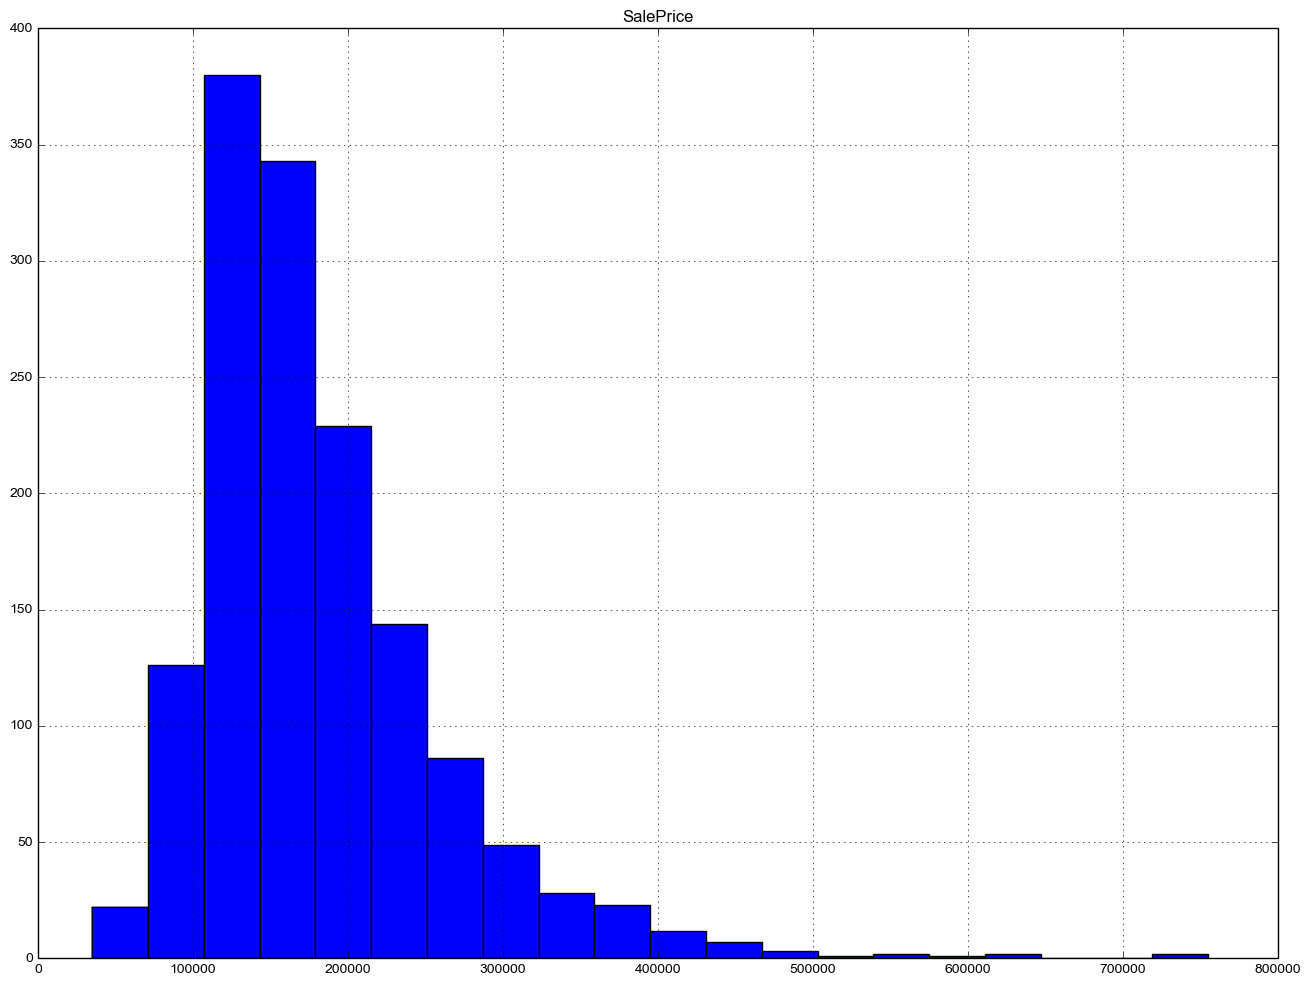

In [166]:
data.hist(column='SalePrice',bins=20);

In [167]:
print( "Skew= %f" % data.SalePrice.skew())
print( "Kurtosis= %f" % data.SalePrice.kurtosis())

Skew= 1.882876
Kurtosis= 6.536282


The histogram plot above of the Salesprice is positively skewed this gives a high value, 1.88, of the skewness measure.
If we want the response variable to assume a normal distribution (curve) its log transformation is a good idea.

## Log Transformation

In [168]:
data1=data.copy()
data1['logSalePrice']=np.log10(data.SalePrice)
data.shape

(1460, 81)

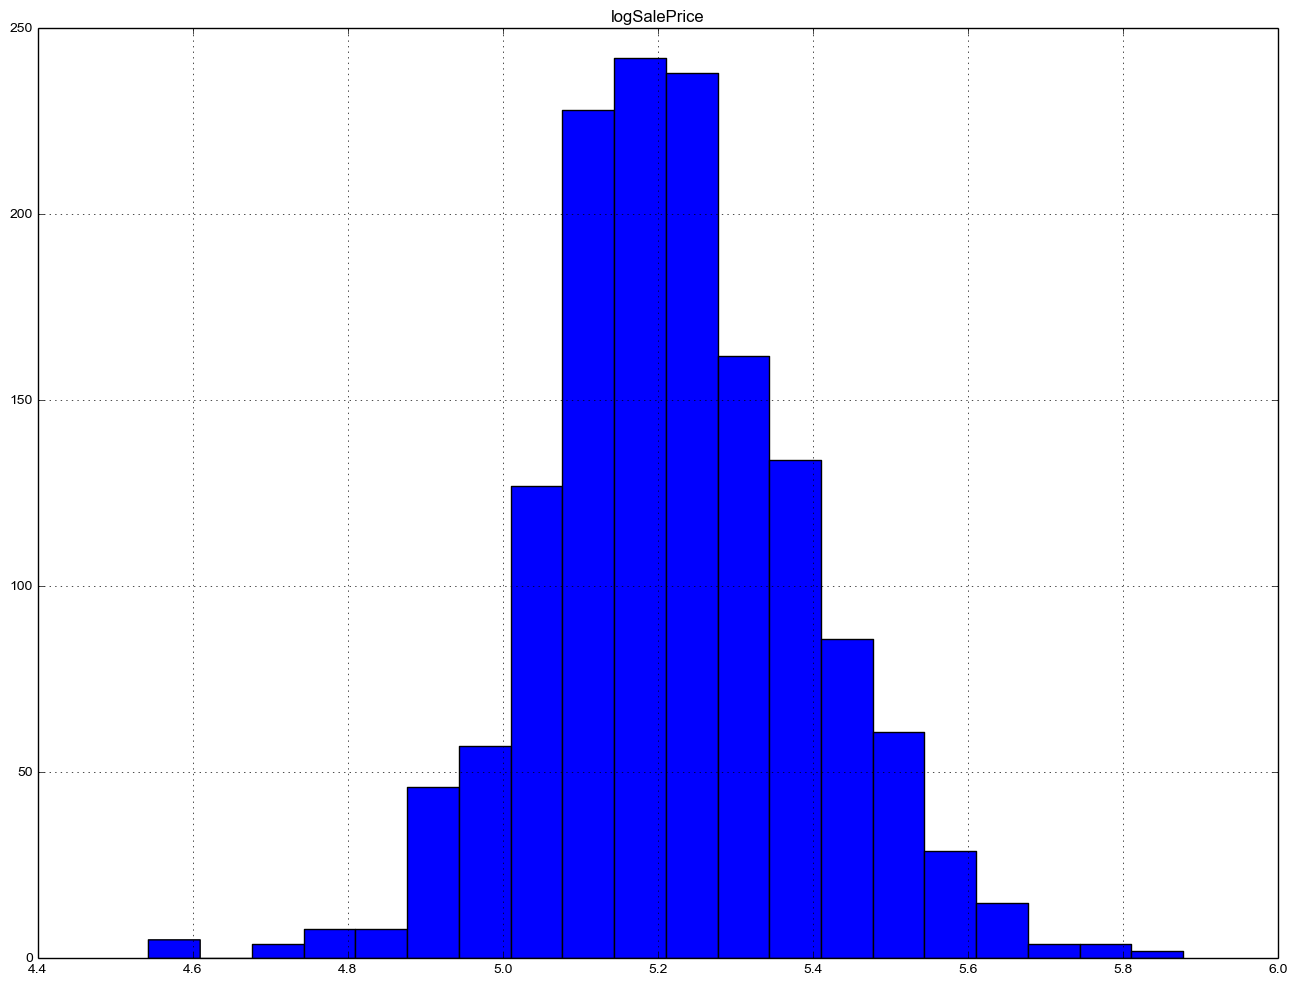

In [169]:
data1.hist(column='logSalePrice',bins=20);

In [170]:
print( "Skew= %f" % data1.logSalePrice.skew())
print( "Kurtosis= %f" % data1.logSalePrice.kurtosis())

Skew= 0.121335
Kurtosis= 0.809532


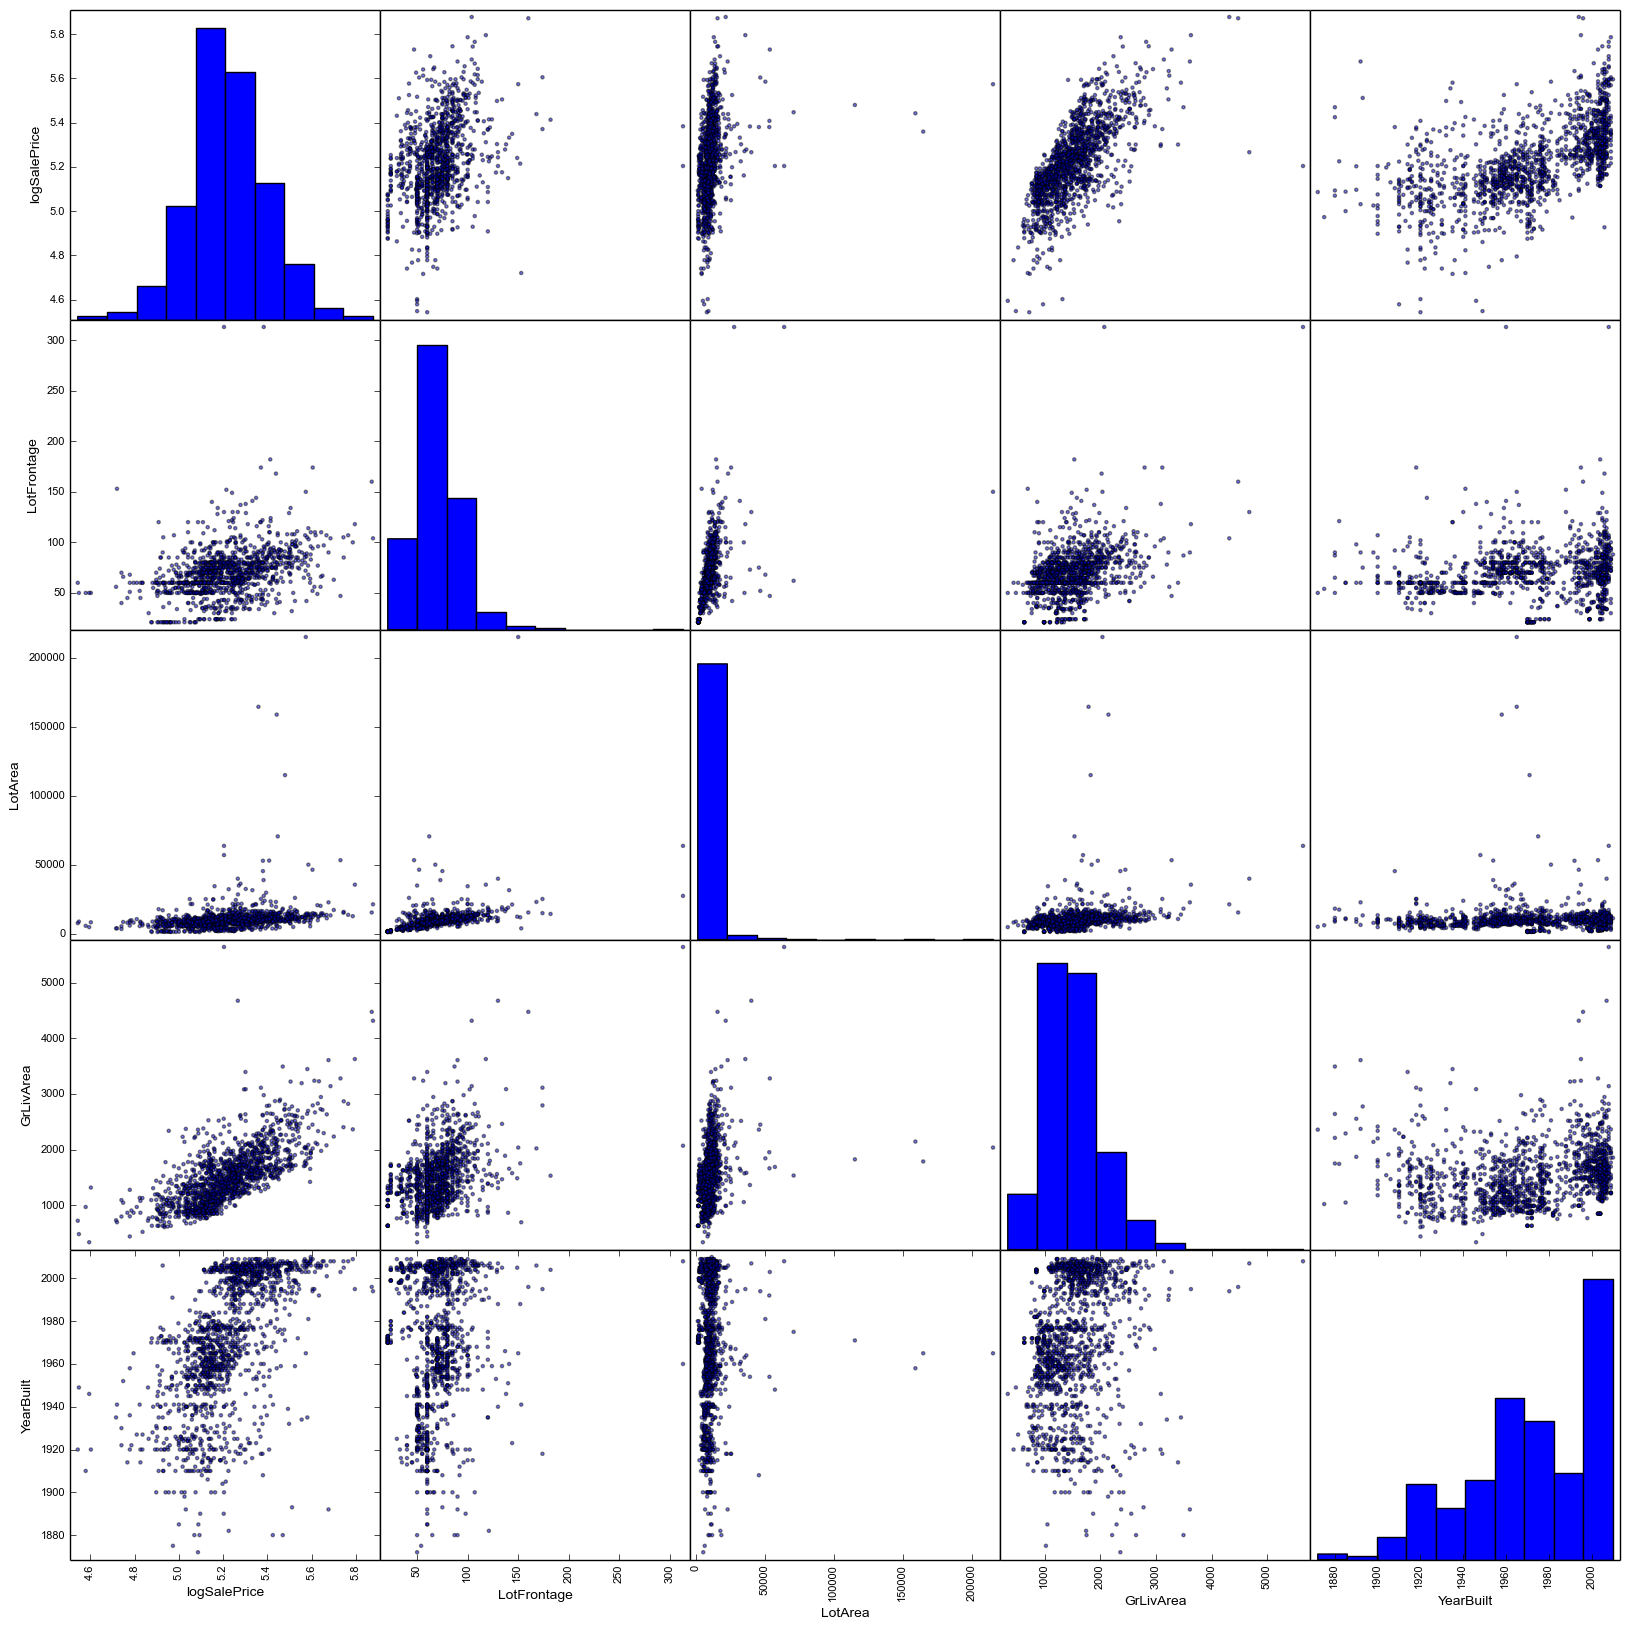

In [171]:
scatter_matrix(data1[['logSalePrice','LotFrontage','LotArea','GrLivArea','YearBuilt']],figsize=[20,20]);

The scatter matrix of the logSalePrice with some continuous features shows a somewhat linear relationship.

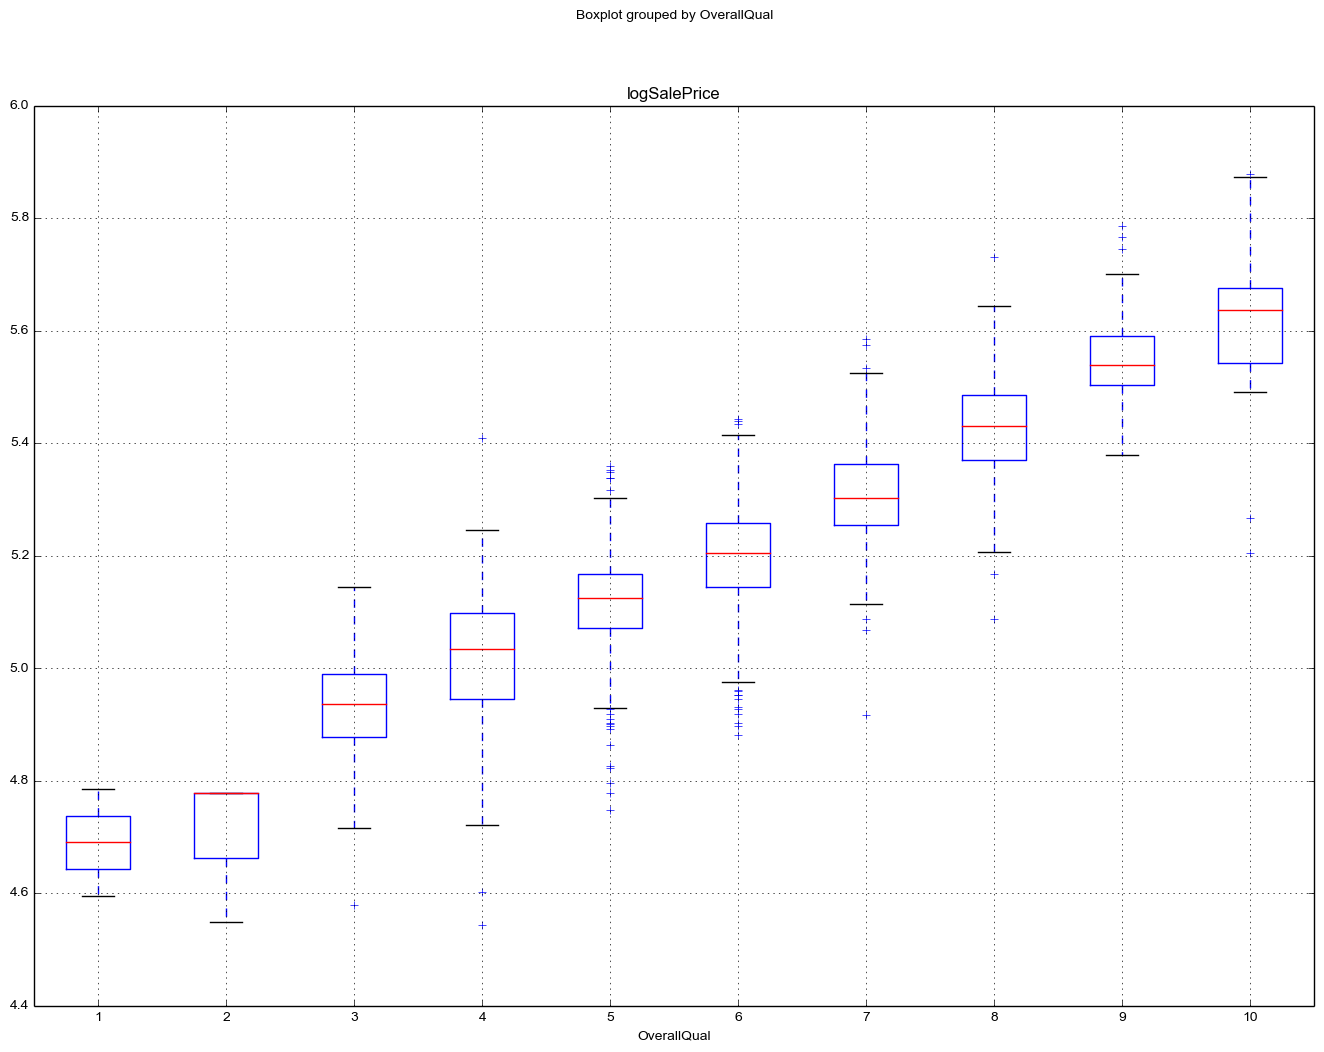

In [172]:
data1.boxplot(column="logSalePrice",by="OverallQual");

Prices of house and Overall quality of the house is a linear relationship as expected, the boxplot below dipict the trend.

## Calculate the number of missing values and percentages

In [173]:
c=0
for i in data1.isnull().sum():
    #c=c+1
    if i>0:
        print(data1.columns[c]+str('  ')+str(i)+'('+str(np.round(i/data1.shape[0]*100,2))+str('%)'))
    c+=1

LotFrontage  259(17.74%)
Alley  1369(93.77%)
MasVnrType  8(0.55%)
MasVnrArea  8(0.55%)
BsmtQual  37(2.53%)
BsmtCond  37(2.53%)
BsmtExposure  38(2.6%)
BsmtFinType1  37(2.53%)
BsmtFinType2  38(2.6%)
Electrical  1(0.07%)
FireplaceQu  690(47.26%)
GarageType  81(5.55%)
GarageYrBlt  81(5.55%)
GarageFinish  81(5.55%)
GarageQual  81(5.55%)
GarageCond  81(5.55%)
PoolQC  1453(99.52%)
Fence  1179(80.75%)
MiscFeature  1406(96.3%)


## Drop features with more than 30% missing values and fill the ones with less

In [174]:
def fill_missing(datax,Trdata=data):
    
    '''This function drops features with over 30% missing observations and 
    fill features with less with either their mean( if continuous) or mode (if categorical)'''
    
    data1=datax.copy()
    
    
    for i in ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','Id','Utilities',
              'Condition2','HouseStyle','RoofMatl','Exterior1st','Exterior2nd','Heating','Electrical','GarageQual']:
        data1.drop(i,1,inplace=True)
    
    
    
    data1.loc[data1.LotFrontage.isnull(), 'LotFrontage'] =Trdata.LotFrontage.mean()
    data1.loc[data1.MasVnrArea.isnull(), 'MasVnrArea'] =Trdata.MasVnrArea.mean()
    for i in ['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
              ,'GarageType','GarageYrBlt','GarageFinish','GarageCond'
        ]:
        data1.loc[data1[i].isnull(), i] =Trdata[i].mode().loc[0]
    
    
    data1 = data1.fillna(Trdata.mode().loc[0])
    
   
    return data1

In [175]:
data_Updated=fill_missing(data1)            #Our working data
Test_kaggle_dataUpdated=fill_missing(Test_kaggle_data)    #Test data from kaggle

## Confirm if all the missing values have been filled in both the train and test data

In [176]:
if any(data_Updated.isnull().sum())>0:
    status = 'Some observations still missing.'
else:
    status = 'No missing observation.'
print(status,'\n')


if any(Test_kaggle_dataUpdated.isnull().sum())>0:
    status = 'Some observations still missing.'
else:
    status = 'No missing observation.'
print(status)

No missing observation. 

No missing observation.


## Indicator variables

In [177]:
def indicator_variables(data):
    
    '''Converts categorical variables into dummy/indicator variables'''
    
    dataDummy=pd.get_dummies(data['MSZoning'],prefix='MSZoning',prefix_sep='_')
    l=[]
    col=data.columns
    for i in col:
        if data[i].dtype=='object':
            l.append(i)
    for i in l[1:]:
        dataDummy=pd.concat([dataDummy, pd.get_dummies(data[i],prefix=i,prefix_sep='_')], axis=1)
    l2=[]
    for i in col:
        if data[i].dtype!='object':
            l2.append(i)
    dataDummy=pd.concat([data[l2],dataDummy],axis=1)
    return  dataDummy,l2    #l2 is a list containing all features except the categorical (object) features

In [178]:
trainFull_T,l2=indicator_variables(data_Updated)
Test_kaggle_dataUpdated_Indcator,l2Test=indicator_variables(Test_kaggle_dataUpdated)

## Data splitting into training and test sets required to build model.

In [179]:
from sklearn import model_selection
train_raw_dummy, test_raw_dummy = model_selection.train_test_split(trainFull_T, test_size = 0.4, random_state=635)

## We compute the correlation of each feature with others

In [180]:
Corr_table=train_raw_dummy.corr() 

In [181]:
#Function to check the features with high correlation with response variable

c=-1
High_corr_features=[]
for i in Corr_table.logSalePrice:
    c+=1
    if i>0.5 or i<-0.5:
        High_corr_features.append(Corr_table.logSalePrice.index[c])
        
High_corr_features.remove('SalePrice')
High_corr_features.remove('logSalePrice')
print('\n','Features with correlation greater than 0.5 or less than -0.5 with the logSalePrice are:','\n')
print(High_corr_features)


 Features with correlation greater than 0.5 or less than -0.5 with the logSalePrice are: 

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc', 'BsmtQual_TA', 'KitchenQual_TA', 'GarageFinish_Unf']


## Normalization

In [182]:
def transform(data1, l=l2,train=train_raw_dummy):
    
    '''This function normalises the continous variable'''
    
    data=data1.copy()
    mean=train.mean()
    std=train.std()
    for i in l:
        data.loc[:,i]=(data[i]-mean[i])/std[i]
    return data

## Separating the response variable from other features for model building.

In [183]:
train_Y=train_raw_dummy.logSalePrice.values #Select the response variable (LogSaleprice) from the dataframe.
train_X=train_raw_dummy.drop(['logSalePrice','SalePrice'],1)#Drop response features from train data


trainFull_Y=trainFull_T.logSalePrice.values #Select the response variable (LogSaleprice) from the dataframe.
trainFull_X=trainFull_T.drop(['logSalePrice','SalePrice'],1)#Drop response features from train data


test_Y=test_raw_dummy.logSalePrice.values
test_X=test_raw_dummy.drop(['logSalePrice','SalePrice'],1) #Drop response features from test data



## Model 1: Model involving only variables with high correlation with response variable

In [184]:
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [185]:
train_XCorr=transform(train_raw_dummy)[High_corr_features] #Select features with high correlation value with the response
train_YCorr=transform(train_raw_dummy)['logSalePrice']
test_XCorr=transform(test_raw_dummy)[High_corr_features]
test_YCorr=transform(test_raw_dummy)['logSalePrice']

In [186]:
lr = LinearRegression()
lr.fit(train_XCorr, train_YCorr)
print('Mean Squared Error: '+str(mean_squared_error(test_YCorr,lr.predict (test_XCorr))) )

Mean Squared Error: 0.204629059195


In [187]:
lr.score(train_XCorr, train_YCorr)

0.83126872428709275

In [188]:
lr.score(test_XCorr, test_YCorr)

0.80267846694102363

However good the $R^2$ (score) is this model only considers the correlated features leaving out other important features to predict House prices. Considering other essential features in the model will probably better the prediction.

## Model 2: Least squares

In [189]:
#least squares
ridge1 = Ridge(alpha=0,normalize=True)
ridge1.fit(train_X, train_Y) # Fit a ridge regression on the training data
pred1 = ridge1.predict(test_X) # Use this model to predict the test data
print('Number of Coefficients: '+str(len([i for i in ridge1.coef_ if i!=0])))
print('Mean Squared Error: '+str(mean_squared_error(test_Y, pred1)) )

Number of Coefficients: 197
Mean Squared Error: 4.36431780447e+21


In [190]:
ridge1.score(train_X, train_Y)

0.92426193004321611

In [191]:
ridge1.score(test_X, test_Y)

-1.4193048670368512e+23

This model score(coefficient of determination, $R^2$) is very bad with high MSE pointing to the fact that there is a problem of overfitting

## Model 3: Ridge regression

In [192]:
alphas = 10**np.linspace(10,-2,100)*0.5       #Penalities to use

In [193]:
ridge2=Ridge(normalize=True)
coefs=[]
for a in alphas:
    ridge2.set_params(alpha=a)
    ridge2.fit(train_X, train_Y)
    coefs.append(ridge2.coef_)

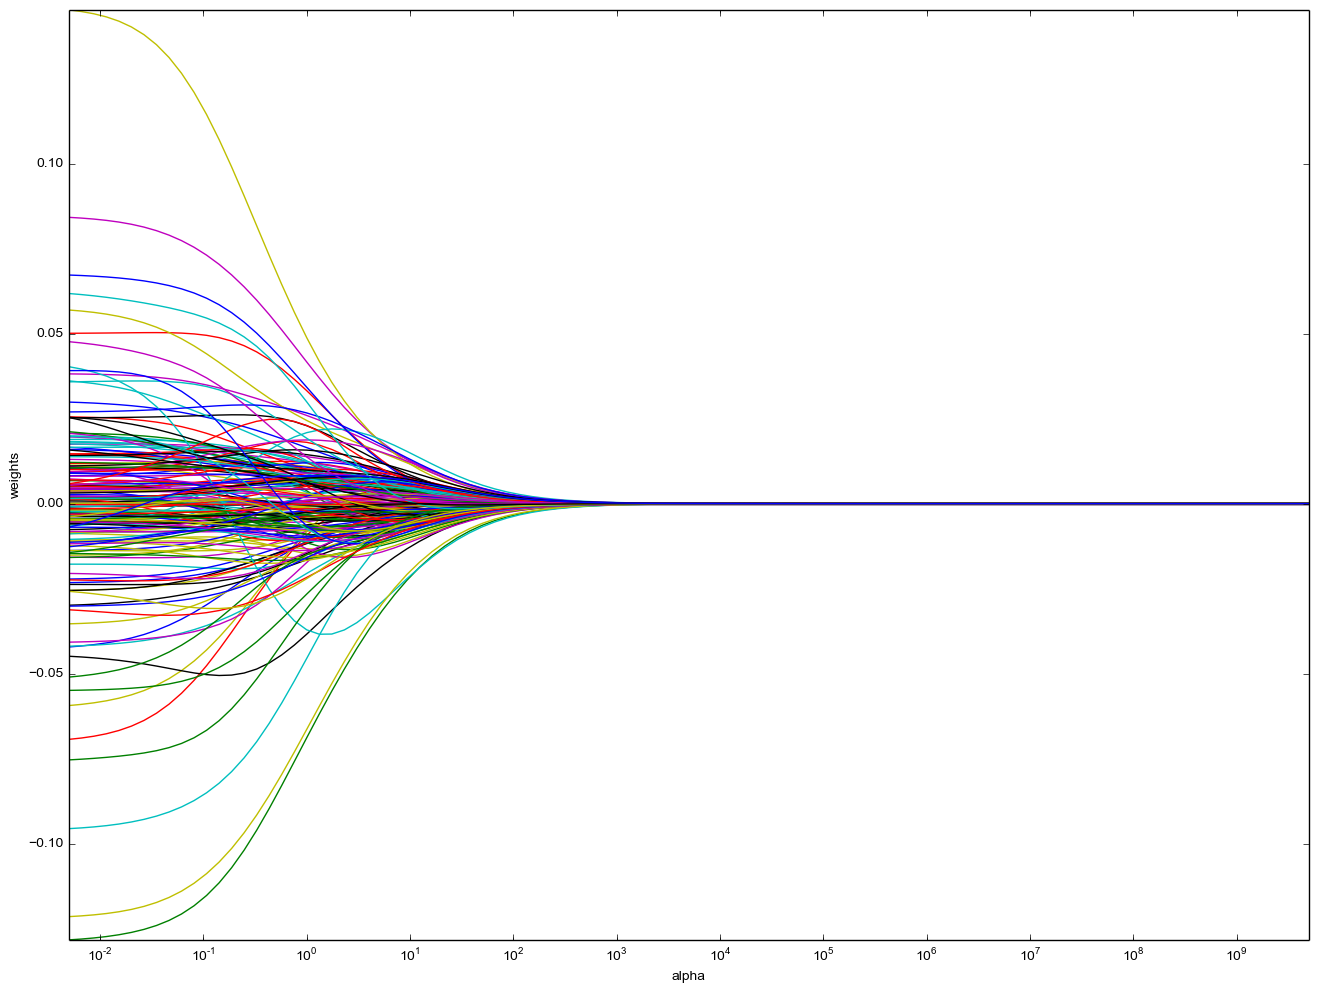

In [194]:
ax=plt.gca()
ax.plot(alphas,coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

## Ridge Cross validation to select the best value of the penalities to use for the model.

In [195]:
#cross validation model

ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error', normalize=True)
ridgecv.fit(train_X, train_Y)
ridgecv.alpha_ #perfoms LOOCV validation, results to selection of value of alpha that has theleast crossvalidation error

0.3289666123287841

In [196]:

ridge3 = Ridge(alpha=ridgecv.alpha_,normalize=True)
ridge3.fit(train_X, train_Y) # Fit a ridge regression on the training data
pred3 = ridge3.predict(test_X) # Use this model to predict the test data

print('Number of Coefficients: '+str(len([i for i in ridge3.coef_ if i!=0])))
print('Mean Squared Error: '+str(mean_squared_error(test_Y, pred3)) )

Number of Coefficients: 193
Mean Squared Error: 0.00423258788335


The number of parameters $\beta$ has reduced to 193 from 197.

In [197]:
ridge3.score(train_X, train_Y)

0.91935307170429337

In [198]:
ridge3.score(test_X, test_Y)

0.86235345700883581

## Model 4: LASSO regression

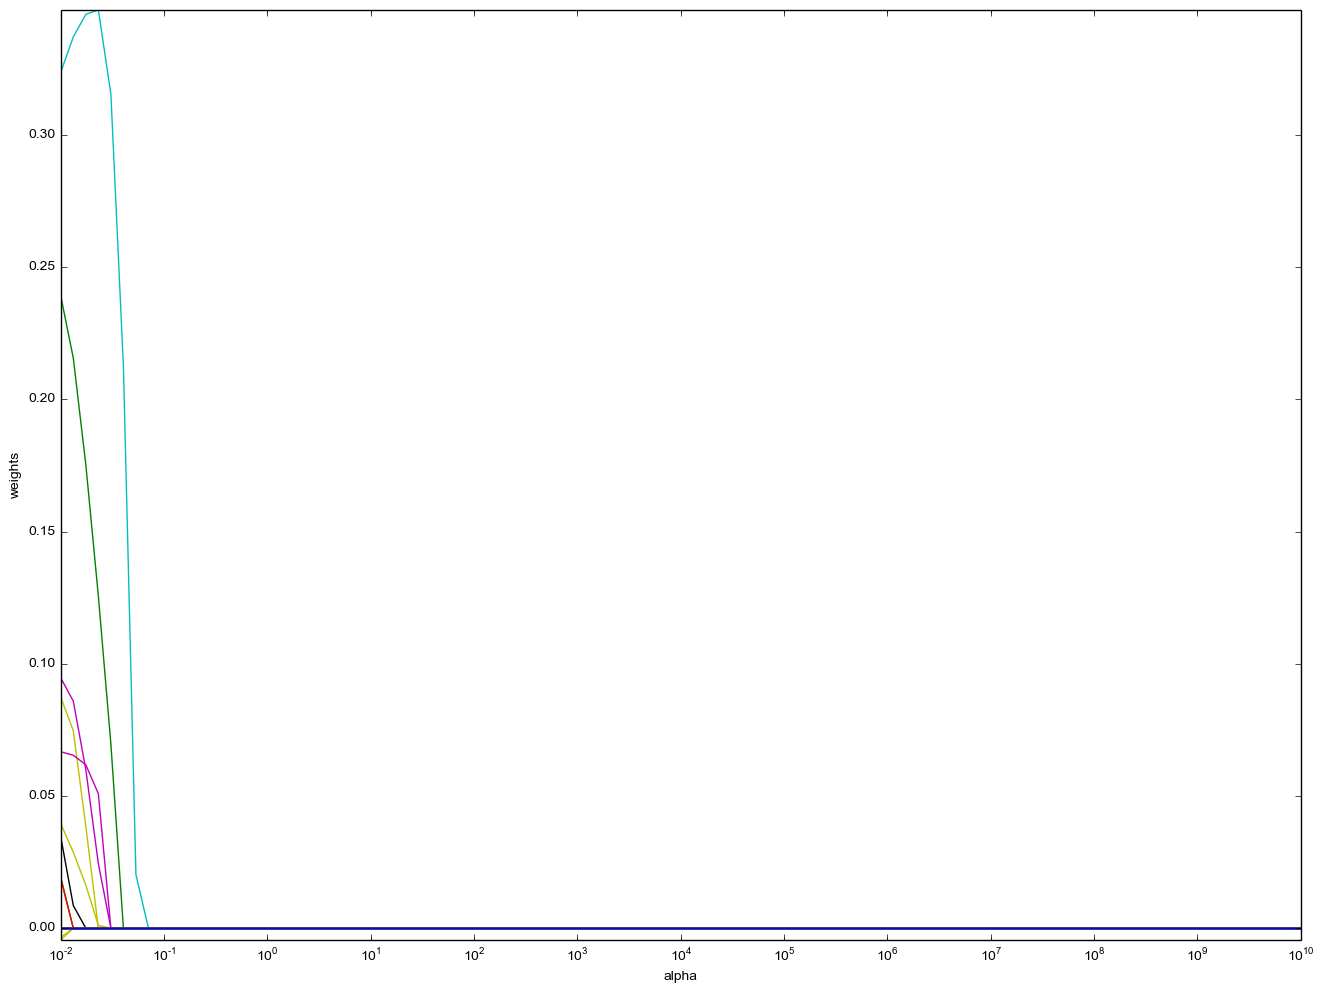

In [199]:
lasso = Lasso(max_iter=100, normalize=True)
coeffs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(train_X), scale(train_Y))
    coeffs.append(lasso.coef_)
    
    
ax = plt.gca()
ax.plot(alphas*2, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


## Lasso Cross validation to select the best penalty to use

In [200]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=1000, normalize=True)
lassocv.fit(train_X, train_Y)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(train_X, train_Y)
mean_squared_error(test_Y, lasso.predict(test_X))
print('Number of Coefficients: '+str(len([i for i in lassocv.coef_ if i!=0])))
print('Mean Squared Error: '+str(mean_squared_error(test_Y, lasso.predict(test_X))) )

Number of Coefficients: 79
Mean Squared Error: 0.00394909926224


In [201]:
lassocv.score(train_X, train_Y)

0.91461698330807828

In [202]:
lassocv.alpha_

7.1585068377795505e-05

In [203]:
lassocv.score(test_X, test_Y)

0.87157269350150168

## Model fit on the Full data set in order to predict TEST_kaggle_data
(To be sent to Kaggle)

In [204]:
lassocvFull = LassoCV(alphas=None, cv=10, max_iter=1000, normalize=True)
lassocvFull.fit(trainFull_X, trainFull_Y)
lasso.set_params(alpha=lassocvFull.alpha_)
lasso.fit(trainFull_X, trainFull_Y)
print('Number of Coefficients: '+str(len([i for i in lassocvFull.coef_ if i!=0])))

Number of Coefficients: 103


In [205]:
TestPredicted=lassocvFull.predict(Test_kaggle_dataUpdated_Indcator)

Antilog of the predicted values since we are working with logSalesPrice

In [206]:
TestPredicted=10**TestPredicted
TestPredicted

array([ 116576.20210606,  147839.23028756,  171481.98492376, ...,
        158772.60961058,  119167.58672403,  235308.62554731])

In [207]:
Test_kaggle_data1=Test_kaggle_data.copy()
Test_kaggle_data1['SalePrice']=TestPredicted
yx=Test_kaggle_data1[['Id','SalePrice']]
yx.to_csv('yz.csv',index=False)

## Random Forests

In [208]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [209]:
n_est=np.arange(5,20)

mse=[]
minmse=10
n=0
m=0
for i in n_est:
    randomForestFit=RandomForestRegressor(n_estimators=i, criterion='mse')
    randomForestFit.fit(train_X, train_Y)
    randomF_Predict=randomForestFit.predict(test_X)
    if mean_squared_error(test_Y, randomF_Predict)<minmse:
        n=i
        minmse=mean_squared_error(test_Y, randomF_Predict)
    #mse.append((mean_squared_error(test_Y, randomF_Predict)) )
print(minmse,n)

0.00398410174233 12


In [210]:
randomForestFit=RandomForestRegressor(n_estimators=n, criterion='mse',random_state=1)
randomForestFit.fit(train_X, train_Y)
randomF_Predict=randomForestFit.predict(test_X)
print('Mean Squared Error: '+str(mean_squared_error(test_Y, randomF_Predict)) )

Mean Squared Error: 0.00410282600927


In [211]:
randomForestFit.score(train_X, train_Y)

0.9689118323620346

In [212]:
randomForestFit.score(test_X, test_Y)

0.86657339853659665

In [213]:
FullPredRandomF=randomForestFit.predict(Test_kaggle_dataUpdated_Indcator)
FullPredRandomF

array([ 5.09560364,  5.20915286,  5.26254322, ...,  5.13231555,
        5.09900654,  5.31200715])

In [214]:
FullPredRandomF=10**FullPredRandomF
FullPredRandomF

array([ 124624.56147991,  161864.96739493,  183038.82678062, ...,
        135617.44207941,  125604.88885822,  205119.5936603 ])

In [215]:
Test_kaggle_data1=Test_kaggle_data.copy()
Test_kaggle_data1['SalePrice']=FullPredRandomF
yx=Test_kaggle_data1[['Id','SalePrice']]
yx.to_csv('RandomForestPred.csv',index=False)

## Gradient boosting regressor

In [217]:
learn_rate=np.linspace(0.05,1,20)

In [218]:
# Randomly give the minimum MSE and the learning rate at which it occur.
n=0
err=10
for i in learn_rate:
    GBR=GradientBoostingRegressor(loss='ls', learning_rate=i, n_estimators=100)
    GBR.fit(train_X, train_Y)
    GBR_predict=GBR.predict(test_X)
    if mean_squared_error(test_Y, GBR_predict)<err:
        err=mean_squared_error(test_Y, GBR_predict)
        n=i
print(err,n)

0.00272922260376 0.15


In [219]:
GBR=GradientBoostingRegressor(loss='ls', learning_rate=n, n_estimators=100, random_state=1)
GBR.fit(train_X, train_Y)
GBR_predict=GBR.predict(test_X)
print('Mean Squared Error: '+str(mean_squared_error(test_Y, GBR_predict)) )

Mean Squared Error: 0.0028607427881


In [220]:
GBR.score(train_X, train_Y)

0.97399037191249571

In [221]:
GBR.score(test_X, test_Y)

0.90696676217459482

## Full model prediction
(To be sent to Kaggle)

In [222]:
FullGBR=GradientBoostingRegressor(loss='ls', learning_rate=n, n_estimators=100)
FullGBR.fit(trainFull_X, trainFull_Y)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.14999999999999999, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [223]:
FullPredGBR=FullGBR.predict(Test_kaggle_dataUpdated_Indcator)
FullPredGBR

array([ 5.10785238,  5.19530236,  5.26202416, ...,  5.15982585,
        5.09107608,  5.39424906])

Antilog of the prediction since we are working with logSalesPrice

In [224]:
FullPredGBR=10**FullPredGBR   
FullPredGBR

array([ 128189.47895846,  156784.22319222,  182820.19090608, ...,
        144486.02737708,  123332.08711179,  247884.31994646])

In [225]:
Test_kaggle_data1=Test_kaggle_data.copy()
Test_kaggle_data1['SalePrice']=FullPredGBR
yx=Test_kaggle_data1[['Id','SalePrice']]
yx.to_csv('GBRPred.csv',index=False)

## SUMMARY

In total 6 model types are developed to predict House prices:
* Linear regression
* Least squares
* Ridge
* Lasso
* Random forest
* Gradient boosting

1. The first model, linear regression, fitted with features having high correlation value with the response variable gave:
    * Mean Squared Error of  0.204629059195

    * score of 0.83 on the train data and 0.80 on the test data.
    
    However, other essential features are not considered.
2. The least squares model, which is the ridge when the penalty equal zero($\alpha$=0), used with all the features resulted in:
    * a total number of 197 Coefficients
    * a very high Mean Squared Error: 4.36431780447e+21
    * a good $R^2$ (0.92) on the train data set but awful on the test data(-1.4193048670368512e+23).
    
    This is a problem of overfitting.
3. Model 3, ridge method, was ran to select the best penalty($\alpha$= 0.329) using the cross validation technique and the result is the following:
    * the number of Coefficients reduce to 193
    * the Mean Squared Error becomes 0.00423258788335
    * Scores of 0.919 and 0.86 respectively on the train and test data.
    
4. The Lasso method with $\alpha$= 7.1585e-05 did better than the ridge model giving:
    * a very much reduced number of Coefficients: 79
    * Mean Squared Error: 0.00394909926224
    * $R^2$ = 0.91 for the train set and 0.87 for the test set
    
5. Random forest model:
    * Mean Squared Error of the test data : 0.00412585504948
    * Train data score 0.97
    * Test data score 0.865
6. Gradient boosting method:
    * Mean Squared Error: 0.00281872756527
    * Train score 0.96
    * Test score 0.91
    
    
    
In general, The Gradient boosting method  did best base on our analysis followed by the Lasso method, however, the lasso method gives the best prediction for the House price data with Kaggle assessment.